#### CLEAN (interative sine-wave fitting)

Especially useful if we are interesting in oberserving a smaller peak, especially if it is next to a larger peak.

Filtering data at certain frequencies

1. Calculate $\alpha(f)$ and $\beta(f)$, then $P = \alpha^{2} + \beta^{2}$

2. Calculate $\alpha(f)\sin(2\pi f_0 t)$ and $\beta(f)$, then $P = \alpha^{2} + \beta^{2}$

The software should be able to:
1) Calculate the power spectrum of a time series (following the Frandsen et al. 1995 Sect 4.2 prescription; see previous slide).
- The user should be able to input the frequency interval for the power spectrum as well as the frequency sampling in the power spectrum. The software may suggest “good” values for these input.

DONE! Here, it suggests good values for df to be 1/5T, and for frequency intervals to be those which observe peaks which are at least 1/8th the size of the maximum peak.


- The software may be built to run through a looped subroutine that calculate the power for each frequency using the Frandsen equations.
DONE!

- It is recommended the software subtracts the mean value of the time series to avoid the “zerofrequency” dominating the spectrum.
DONE! This is done using the signal.detrend() function.

- Input/Output should be in microHz, but make sure you feed the harmonic functions with angular frequency.
DONE! the mHz part. But, I don't think i fed the harmonic functions with angular frequency... yet my results look good?

- The output should be a file containing all the values for the power (or amplitude) for all the user defined frequencies. In addition, let the software plot the power spectrum on the screen or to file.

- To test the software: 
(1) Calculate the power spectrum of a simple harmonic oscillator (try vary the frequency, and amplitude of the oscillator and the length of the time series, and show it behaves as it should). 

(2) Calculate the power spectrum of stellar data (get it from www.physics.usyd.edu.au/~stello/timeseries). Try plot a spectrum of STAR1, STAR2, or the Sun where you zoom in on some of the oscillation frequencies. Show that the stars are oscillating in modes that can not be characterized by a number of simple harmonic oscillations (each mode is not described by a single sinc-like function). 

----------------------------------

2) Make your software able to use statistical weights associated with each data point in the time series.
- To test your weight functionality, try plot the power spectrum of Procyon with and without weights (get it from www.physics.usyd.edu.au/~stello/timeseries) using the SNR weight scheme/column. 
DONE! But have not used Procyon... I will need to ask Dennis what each of the columns are representing...

Also, might be able to add a feature which calculates the scatter using a box average (see 37 of L4)

----------------------------------

3) Enable the software to calculate the spectral window at a given frequency (calculate the power for a simple sine having frequency f and a cosine having frequency f. The average power spectrum is the best value for the window at frequency f, hence Window=0.5[P(sin)+P(cos)]). It is often best to choose f = 0.5fNyquist. 


To test the spectral window calculation: 
- (1) Generate time series consisting of two equal-length segments and vary the gap between the two segments from no-gap till a gap of, say, four times the length of each segment. 
DONE!

- (2) Calculate the spectral window for each of your time series (single segment, two segments without gap, two segments with small gap, two segments with larger gap, etc) and show how the change in gap length changes the spectral window. 

- (3) Describe the changes and why you see what you see.


In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import cftime
import PyFT as pyft

### Generate Mock Data

In [ ]:
# Generate data WITHOUT GAPS
pyft.generate_data(dt=0.05, T_start=0, T_end=100, noise_level_1=0.2, noise_level_2=0.2*10, verbose=1)

# Generate data WITH GAPS
pyft.generate_data_with_gaps(dt=0.05, T_start=0, T_end=200, w=2, a0=3, phase=0, yshift=10, noise=False, noise_level=0.2, gap_multiplier=4, lambdas=2.5, verbose=1)

### Main Code as Function

Average timestep: 0.002279830611019239


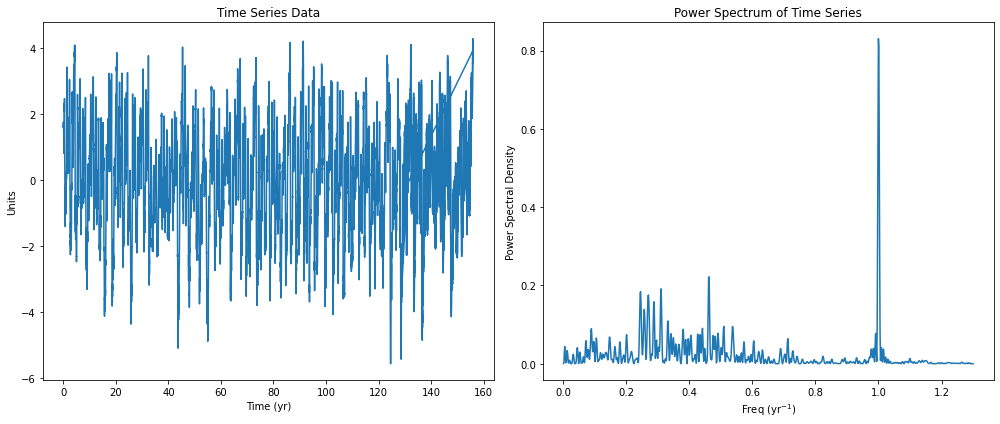

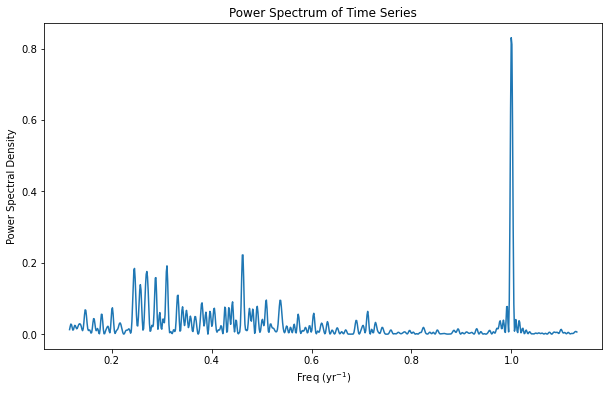

In [2]:
def power_spectrum(data_path, time_column, column_of_interest, df=None, f_int=None, time_units=["s", "ms"], unc_column=None, verbose=2, recommendations=False, calc_unc=False, plotting=2):
    
    from scipy import signal
    import os
    import numpy as np
    import PyFT as pyft
    import matplotlib.pyplot as plt

    #------------------------------------------
    # READING, CLEANING, & STRUCTURING DATA
    #------------------------------------------

    # Convert time units
    conversion_factor = pyft.conversion_factor(time_units[0], time_units[1])

    # Process the data
    current_dir = os.getcwd()
    filename, extension = data_path.rsplit('.', 1)
    ds = pyft.process_df(data_path, time_column, column_of_interest)

    signal_column = 'signal'

    # Calculate key values
    dt = pyft.calc_dt(ds['time'])  # Average timestep of data
    print(f"Average timestep: {dt}")
    T = (ds['time'][-1] - ds['time'][0]).item()  # Time length of data
    f_nyq = 1 / (2 * dt)  # Nyquist Frequency (in chosen units)
    df_rec = 1 / (5 * T)  # Recommended sampling frequency (oversampling using df = 1/5T)
    f_int_nyq = [0, f_nyq * 0.9]  # Recommended frequency interval (from 0 to 0.9 * Nyquist Frequency)

    # Print recommended sampling frequency if enabled
    if recommendations:
        print(f"Recommended sampling frequency: {df_rec:.4f} Hz.")

    # Check and set default values for frequency step and interval
    if df is None:
        if verbose > 0:
            print(f"No frequency step given. Using recommended df = {df_rec:.4f}")
        df = df_rec

    if f_int is None:
        if verbose > 0:
            print(f"No frequency interval given. Testing from 0 to 0.9 * Nyquist Frequency, {f_int_nyq} Hz.")
        f_int = f_int_nyq

    # Create frequency array
    freq = np.arange(f_int[0], f_int[1], step=df)
    ds.coords['freq'] = freq

    #------------------------------------------
    # FOURIER TRANSFORM CODE
    #------------------------------------------
    # Precompute sin(f*time) and cos(f*time)
    sin_vals = np.sin(2 * np.pi * np.outer(freq, ds['time']))
    cos_vals = np.cos(2 * np.pi * np.outer(freq, ds['time']))

    # Compute s, c, ss, cc, sc
    s_data = np.sum(ds['weights'].values * ds[signal_column].values * sin_vals, axis=1)
    c_data = np.sum(ds['weights'].values * ds[signal_column].values * cos_vals, axis=1)
    ss_data = np.sum(ds['weights'].values * sin_vals ** 2, axis=1)
    cc_data = np.sum(ds['weights'].values * cos_vals ** 2, axis=1)
    sc_data = np.sum(ds['weights'].values * cos_vals * sin_vals, axis=1)

    # Add computed values to the dataset
    ds['s'] = ('freq', s_data)
    ds['c'] = ('freq', c_data)
    ds['ss'] = ('freq', ss_data)
    ds['cc'] = ('freq', cc_data)
    ds['sc'] = ('freq', sc_data)

    # Compute alpha and beta
    alpha = (ds['s'] * ds['cc'] - ds['c'] * ds['sc']) / (ds['ss'] * ds['cc'] - ds['sc'] ** 2)
    beta = (ds['c'] * ds['ss'] - ds['s'] * ds['sc']) / (ds['ss'] * ds['cc'] - ds['sc'] ** 2)
    ds = ds.drop_vars(['s', 'c', 'ss', 'cc', 'sc'])

    # Add alpha and beta to the dataset
    ds['alpha'] = ('freq', alpha.data)
    ds['beta'] = ('freq', beta.data)

    # Compute power spectrum
    P = ds['alpha'] ** 2 + ds['beta'] ** 2
    ds['P'] = ('freq', P.data)

    ds['freq'] = ds['freq'] / conversion_factor
    ds['time'] = ds['time']

    #------------------------------------------
    # PLOTTING & FILE OUTPUT
    #------------------------------------------
    if plotting >= 1:
        os.makedirs(current_dir + '/plots', exist_ok=True)

        # Create a figure and two subplots
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

        # Plot the time series data on the first subplot
        ds[signal_column].plot(ax=axes[0])
        axes[0].set_title("Time Series Data")
        axes[0].set_xlabel(f"Time ({time_units[0]})")
        axes[0].set_ylabel("Units")

        # Plot the power spectral density on the second subplot
        ds['P'].plot(ax=axes[1])
        axes[1].set_title("Power Spectrum of Time Series")
        axes[1].set_xlabel(f"Freq ({time_units[1]}$^{{-1}}$)")
        axes[1].set_ylabel("Power Spectral Density")

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Display the plots
        plt.savefig(f"plots/{filename}_PS.png")
        plt.show()
        plt.close()

    os.makedirs(current_dir + '/PS_Data', exist_ok=True)
    ds.to_netcdf(f'PS_Data/{filename}_PS.nc')

    #------------------------------------------
    # FINDING RECOMMENDED F INTERVAL
    #------------------------------------------
    # Find the frequency interval containing significant peaks
    max_idx = np.nanargmax(ds['P'].values)
    max_freq = ds['freq'].values[max_idx]  # Frequency with maximum power
    max_P = ds['P'].values[max_idx]  # Maximum power
    peak_thresh = 1 / 8 * max_P  # Threshold for significant peaks

    # Identify frequencies with power above the threshold
    above_threshold_indices = np.where(ds['P'].values > peak_thresh)[0]
    max_fthresh = ds['freq'].values[above_threshold_indices].max()
    min_fthresh = ds['freq'].values[above_threshold_indices].min()

    # Define the recommended frequency interval
    f_int_rec = [min_fthresh - 20 * 1 / (T * conversion_factor), max_fthresh + 20 * 1 / (T * conversion_factor)]
    if recommendations:
        print(f"Recommended frequency interval: {f_int_rec} /{time_units[1]}.")

    # Plot the zoomed-in power spectrum if plotting mode is 2
    if plotting == 2:
        plt.figure(figsize=(10, 6))

        # Select the power spectral density within the recommended frequency range
        P_slice = ds['P'].sel(freq=slice(f_int_rec[0], f_int_rec[1]))

        # Plot the power spectral density for the selected frequency range
        P_slice.plot()
        plt.title("Power Spectrum of Time Series")
        plt.xlabel(f"Freq ({time_units[1]}$^{{-1}}$)")
        plt.ylabel("Power Spectral Density")
        plt.savefig(f"plots/{filename}_PS_ZOOMED.png")
        plt.show()
        plt.close()

##################
# USER INPUTS
##################

# ---- MOCK DATA ----
# data_path = 'mockdata_gaps.csv'
# column_of_interest = 'signal_4
# time_column = 'time_4'
# time_units = ['s', 'ms'] # ['from_units, to_units']
# unc_column = 'unc'

# df = None  # (default, NONE). Frequency step in from_units.
# f_int = None  # (default, NONE). Frequency interval in from_units.

# ---- ENSO DATA ----
data_path = 'tos.nc'  # (mandatory) Path to CSV file.
column_of_interest = 'signal_1'
time_column = 'time'
time_units = ['yr', 'yr'] # ['from_units, to_units']
unc_column = 'unc'

df = 0.0013  # (default, NONE). Frequency step in from_units.
f_int = [0,1.3]  # (default, NONE). Frequency interval in from_units.


verbose = 5
recommendations = True
calc_unc = True
plotting = 2 # 0 = no plots, 1 = plot frequency domain within interval, 2 = plot zoomed-in frequency domain within recommended interval.

##################
# USING FUNCTION
##################

power_spectrum(data_path, time_column, column_of_interest, df=df, f_int=f_int, 
               time_units = time_units, unc_column=None, 
               verbose=2, recommendations=False, calc_unc=False, plotting=2)